# 05. Temporal Semantic Network Analysis (시계열 의미 연결망 분석)
## 2014-2024년 연도별 토픽 진화 및 네트워크 구조 변화 추적

이 노트북은 단순한 정적 네트워크가 아닌 **시간에 따른 네트워크 진화**를 분석합니다.

**분석 내용:**
1. 연도별 키워드 네트워크 생성 (2014~2024)
2. 시계열 중심성 변화 추적 (Degree Centrality Evolution)
3. 토픽 전환 경로 시각화 (DRAM → HBM 등)
4. 기업별 전략 진화 비교 (Samsung vs SK Hynix)
5. 신규 등장 키워드 탐지 (Emerging Topics)
6. 연도별 네트워크 시각화 (Small Multiples)


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
sns.set(style="whitegrid")
font_name = "NanumGothic"
plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['figure.figsize'] = (16, 10)

# 데이터 경로
DATA_DIR = "../data/raw"
OUTPUT_DIR = "../reports/Figure"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Environment Setup Complete. Using font: {font_name}")


Environment Setup Complete. Using font: NanumGothic


## 1. 데이터 로딩 및 전처리


In [2]:
def load_and_preprocess():
    """뉴스 데이터 로드 및 연도 정보 추가"""
    sam_df = pd.read_csv(os.path.join(DATA_DIR, "samsung_news.csv"))
    sk_df = pd.read_csv(os.path.join(DATA_DIR, "skhynix_news.csv"))
    
    sam_df['company'] = 'Samsung'
    sk_df['company'] = 'SKHynix'
    
    df = pd.concat([sam_df, sk_df], ignore_index=True)
    df['text'] = df['title'].fillna('') + " " + df['content'].fillna('')
    df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
    df = df.dropna(subset=['date']).sort_values('date')
    
    # 연도 추출
    df['year'] = df['date'].dt.year
    
    # 2014-2024년 필터링
    df = df[(df['year'] >= 2014) & (df['year'] <= 2024)]
    
    def clean_text(text):
        text = str(text)
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    df['processed_text'] = df['text'].apply(clean_text)
    return df

df = load_and_preprocess()
print(f"Total Data: {len(df)} records")
print(f"Years: {sorted(df['year'].unique())}")
print(f"\nData by Year:")
print(df.groupby(['year', 'company']).size().unstack(fill_value=0))


Total Data: 2840 records
Years: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]

Data by Year:
company  SKHynix  Samsung
year                     
2014           0       74
2015           3      111
2016          94       70
2017         145      104
2018         198      144
2019         180      152
2020         202      120
2021         218      137
2022         160      223
2023         188       94
2024         136       87


## 2. 키워드 추출


In [3]:
def extract_keywords_advanced(text):
    """향상된 키워드 추출: 기술, 제품, 응용 분야 모두 포함"""
    if not isinstance(text, str):
        return []
    
    # 확장된 키워드 세트
    target_keywords = [
        # 메모리 기술
        'HBM', 'HBM2', 'HBM3', 'HBM3E',
        'DDR', 'DDR4', 'DDR5', 'LPDDR',
        'DRAM', 'NAND', 'SSD', 'V-NAND',
        
        # 제조 기술
        'EUV', 'GAA', '파운드리', '패키징',
        '10나노', '7나노', '5나노', '3나노', '2나노',
        
        # 응용 분야
        'AI', '인공지능', '머신러닝', 'GPU',
        '서버', '데이터센터', '클라우드',
        '자율주행', '전기차', '차량용',
        '스마트폰', '모바일', '5G',
        
        # 기업/파트너
        '엔비디아', 'NVIDIA', 'AMD', 'Intel',
        'TSMC', '삼성전자', 'SK하이닉스',
        
        # 비즈니스
        '양산', '개발', '출시', '공급',
        '투자', '매출', '수율', '점유율',
        
        # 차세대 기술
        'CXL', 'PIM', 'CIS', 'AP',
        '하이브리드본딩', '3D', 'TSV'
    ]
    
    found = set()
    text_upper = text.upper()
    
    for keyword in target_keywords:
        keyword_upper = keyword.upper()
        if keyword_upper in text_upper or keyword in text:
            found.add(keyword)
    
    return list(found)

# 전체 데이터에 키워드 추출 적용
df['keywords'] = df['processed_text'].apply(extract_keywords_advanced)
df['keyword_count'] = df['keywords'].apply(len)

print("Keyword extraction completed.")
print(f"Articles with keywords: {len(df[df['keyword_count'] > 0])} / {len(df)}")


Keyword extraction completed.
Articles with keywords: 2691 / 2840


## 3. 연도별 네트워크 생성


In [4]:
def build_yearly_networks(df, company_filter=None, min_edge_weight=3):
    """
    연도별 네트워크 생성
    
    Parameters:
    - df: 전체 데이터프레임
    - company_filter: 'Samsung', 'SKHynix', 또는 None (전체)
    - min_edge_weight: 최소 공출현 횟수
    
    Returns:
    - dict: {year: networkx.Graph}
    """
    if company_filter:
        df = df[df['company'] == company_filter].copy()
    
    yearly_networks = {}
    years = sorted(df['year'].unique())
    
    for year in years:
        year_df = df[df['year'] == year]
        
        # 키워드 공출현 계산
        edge_list = []
        for keywords in year_df['keywords']:
            if len(keywords) > 1:
                edge_list.extend(combinations(sorted(keywords), 2))
        
        edge_counts = Counter(edge_list)
        
        # 네트워크 구축
        G = nx.Graph()
        for (u, v), count in edge_counts.items():
            if count >= min_edge_weight:
                G.add_edge(u, v, weight=count)
        
        yearly_networks[year] = G
        print(f"Year {year}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    return yearly_networks

# 전체 데이터 네트워크
print("=== Building Yearly Networks (All Companies) ===")
networks_all = build_yearly_networks(df, company_filter=None, min_edge_weight=5)

# 기업별 네트워크
print("\n=== Building Yearly Networks (Samsung) ===")
networks_samsung = build_yearly_networks(df, company_filter='Samsung', min_edge_weight=3)

print("\n=== Building Yearly Networks (SK Hynix) ===")
networks_skhynix = build_yearly_networks(df, company_filter='SKHynix', min_edge_weight=3)


=== Building Yearly Networks (All Companies) ===
Year 2014: 12 nodes, 29 edges
Year 2015: 19 nodes, 73 edges
Year 2016: 28 nodes, 174 edges
Year 2017: 38 nodes, 309 edges
Year 2018: 40 nodes, 429 edges
Year 2019: 46 nodes, 497 edges
Year 2020: 46 nodes, 551 edges
Year 2021: 49 nodes, 627 edges
Year 2022: 50 nodes, 609 edges
Year 2023: 53 nodes, 639 edges
Year 2024: 48 nodes, 573 edges

=== Building Yearly Networks (Samsung) ===
Year 2014: 18 nodes, 67 edges
Year 2015: 23 nodes, 147 edges
Year 2016: 21 nodes, 103 edges
Year 2017: 31 nodes, 249 edges
Year 2018: 37 nodes, 386 edges
Year 2019: 40 nodes, 396 edges
Year 2020: 33 nodes, 245 edges
Year 2021: 42 nodes, 365 edges
Year 2022: 41 nodes, 342 edges
Year 2023: 37 nodes, 342 edges
Year 2024: 35 nodes, 347 edges

=== Building Yearly Networks (SK Hynix) ===
Year 2015: 0 nodes, 0 edges
Year 2016: 28 nodes, 189 edges
Year 2017: 36 nodes, 294 edges
Year 2018: 37 nodes, 331 edges
Year 2019: 44 nodes, 520 edges
Year 2020: 45 nodes, 700 edges


## 4. 중심성 시계열 분석


In [5]:
def analyze_centrality_evolution(networks_dict):
    """
    연도별 중심성 변화 추적
    
    Returns:
    - DataFrame: 연도별 주요 키워드의 중심성 점수
    """
    centrality_data = []
    
    for year, G in sorted(networks_dict.items()):
        if G.number_of_nodes() == 0:
            continue
        
        # Degree Centrality 계산
        degree_cent = nx.degree_centrality(G)
        
        # 가중치 반영한 Weighted Degree
        weighted_degree = dict(G.degree(weight='weight'))
        
        for node in G.nodes():
            centrality_data.append({
                'year': year,
                'keyword': node,
                'degree_centrality': degree_cent.get(node, 0),
                'weighted_degree': weighted_degree.get(node, 0)
            })
    
    df_cent = pd.DataFrame(centrality_data)
    return df_cent

# 전체 중심성 분석
centrality_all = analyze_centrality_evolution(networks_all)
centrality_samsung = analyze_centrality_evolution(networks_samsung)
centrality_skhynix = analyze_centrality_evolution(networks_skhynix)

print("Centrality evolution analysis completed.")
print(f"\nTotal keyword-year pairs: {len(centrality_all)}")


Centrality evolution analysis completed.

Total keyword-year pairs: 429


## 5. 주요 키워드 중심성 변화 시각화


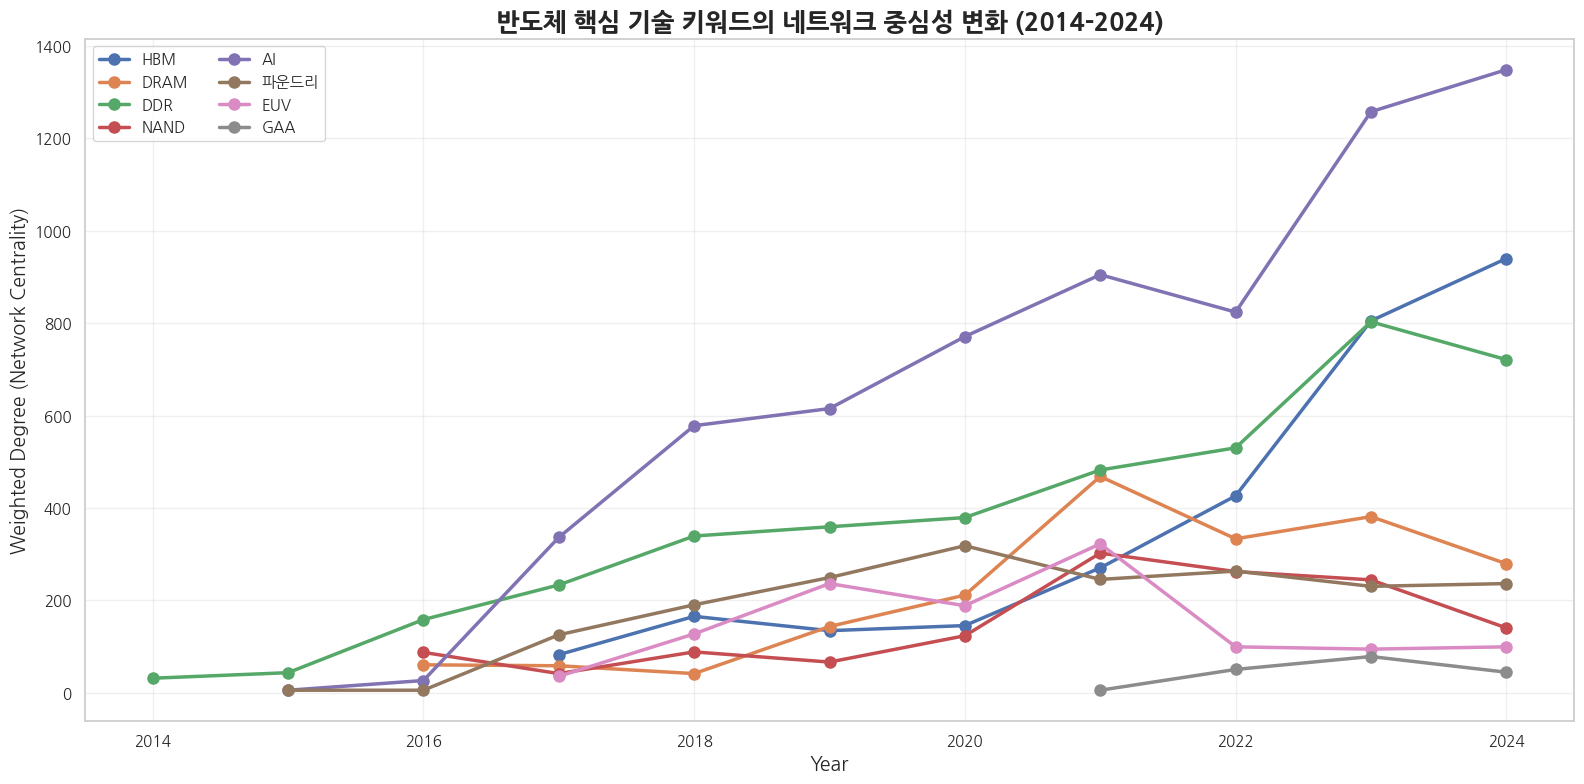

In [6]:
def plot_keyword_evolution(df_cent, keywords_to_track, title="Keyword Centrality Evolution"):
    """특정 키워드들의 중심성 변화를 시계열 그래프로 표현"""
    plt.figure(figsize=(16, 8))
    
    for keyword in keywords_to_track:
        subset = df_cent[df_cent['keyword'] == keyword].sort_values('year')
        if len(subset) > 0:
            plt.plot(subset['year'], subset['weighted_degree'], 
                    marker='o', linewidth=2.5, markersize=8, label=keyword)
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Weighted Degree (Network Centrality)", fontsize=14)
    plt.legend(loc='best', fontsize=11, ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 주요 기술 키워드 추적
tech_keywords = ['HBM', 'DRAM', 'DDR', 'NAND', 'AI', '파운드리', 'EUV', 'GAA']
plot_keyword_evolution(centrality_all, tech_keywords, 
                      title="반도체 핵심 기술 키워드의 네트워크 중심성 변화 (2014-2024)")


## 6. 연도별 Top 키워드 히트맵


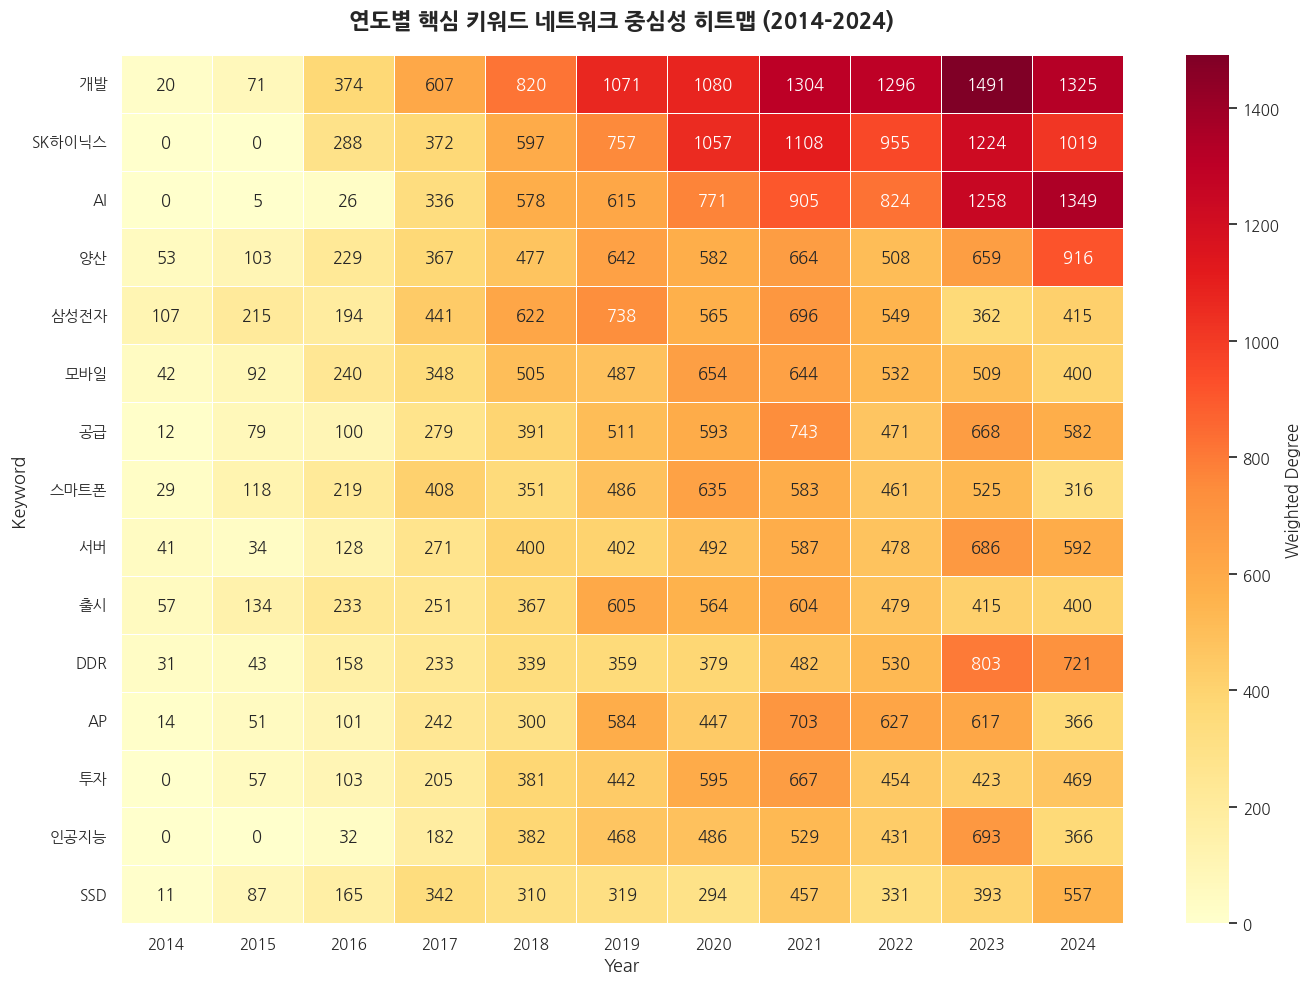

In [7]:
def create_temporal_heatmap(df_cent, top_n=15):
    """연도별 주요 키워드의 중심성을 히트맵으로 시각화"""
    # 전체 기간에서 가장 중요한 키워드 선택
    top_keywords = (df_cent.groupby('keyword')['weighted_degree']
                    .sum()
                    .sort_values(ascending=False)
                    .head(top_n)
                    .index.tolist())
    
    # 피벗 테이블 생성
    pivot_data = df_cent[df_cent['keyword'].isin(top_keywords)].pivot_table(
        index='keyword',
        columns='year',
        values='weighted_degree',
        fill_value=0
    )
    
    # 키워드를 전체 중심성 합계로 정렬
    pivot_data['total'] = pivot_data.sum(axis=1)
    pivot_data = pivot_data.sort_values('total', ascending=False).drop('total', axis=1)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', 
                linewidths=0.5, cbar_kws={'label': 'Weighted Degree'})
    plt.title('연도별 핵심 키워드 네트워크 중심성 히트맵 (2014-2024)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=13)
    plt.ylabel('Keyword', fontsize=13)
    plt.tight_layout()
    plt.show()
    
    return pivot_data

heatmap_data = create_temporal_heatmap(centrality_all, top_n=15)


## 7. 기업별 전략 진화 비교


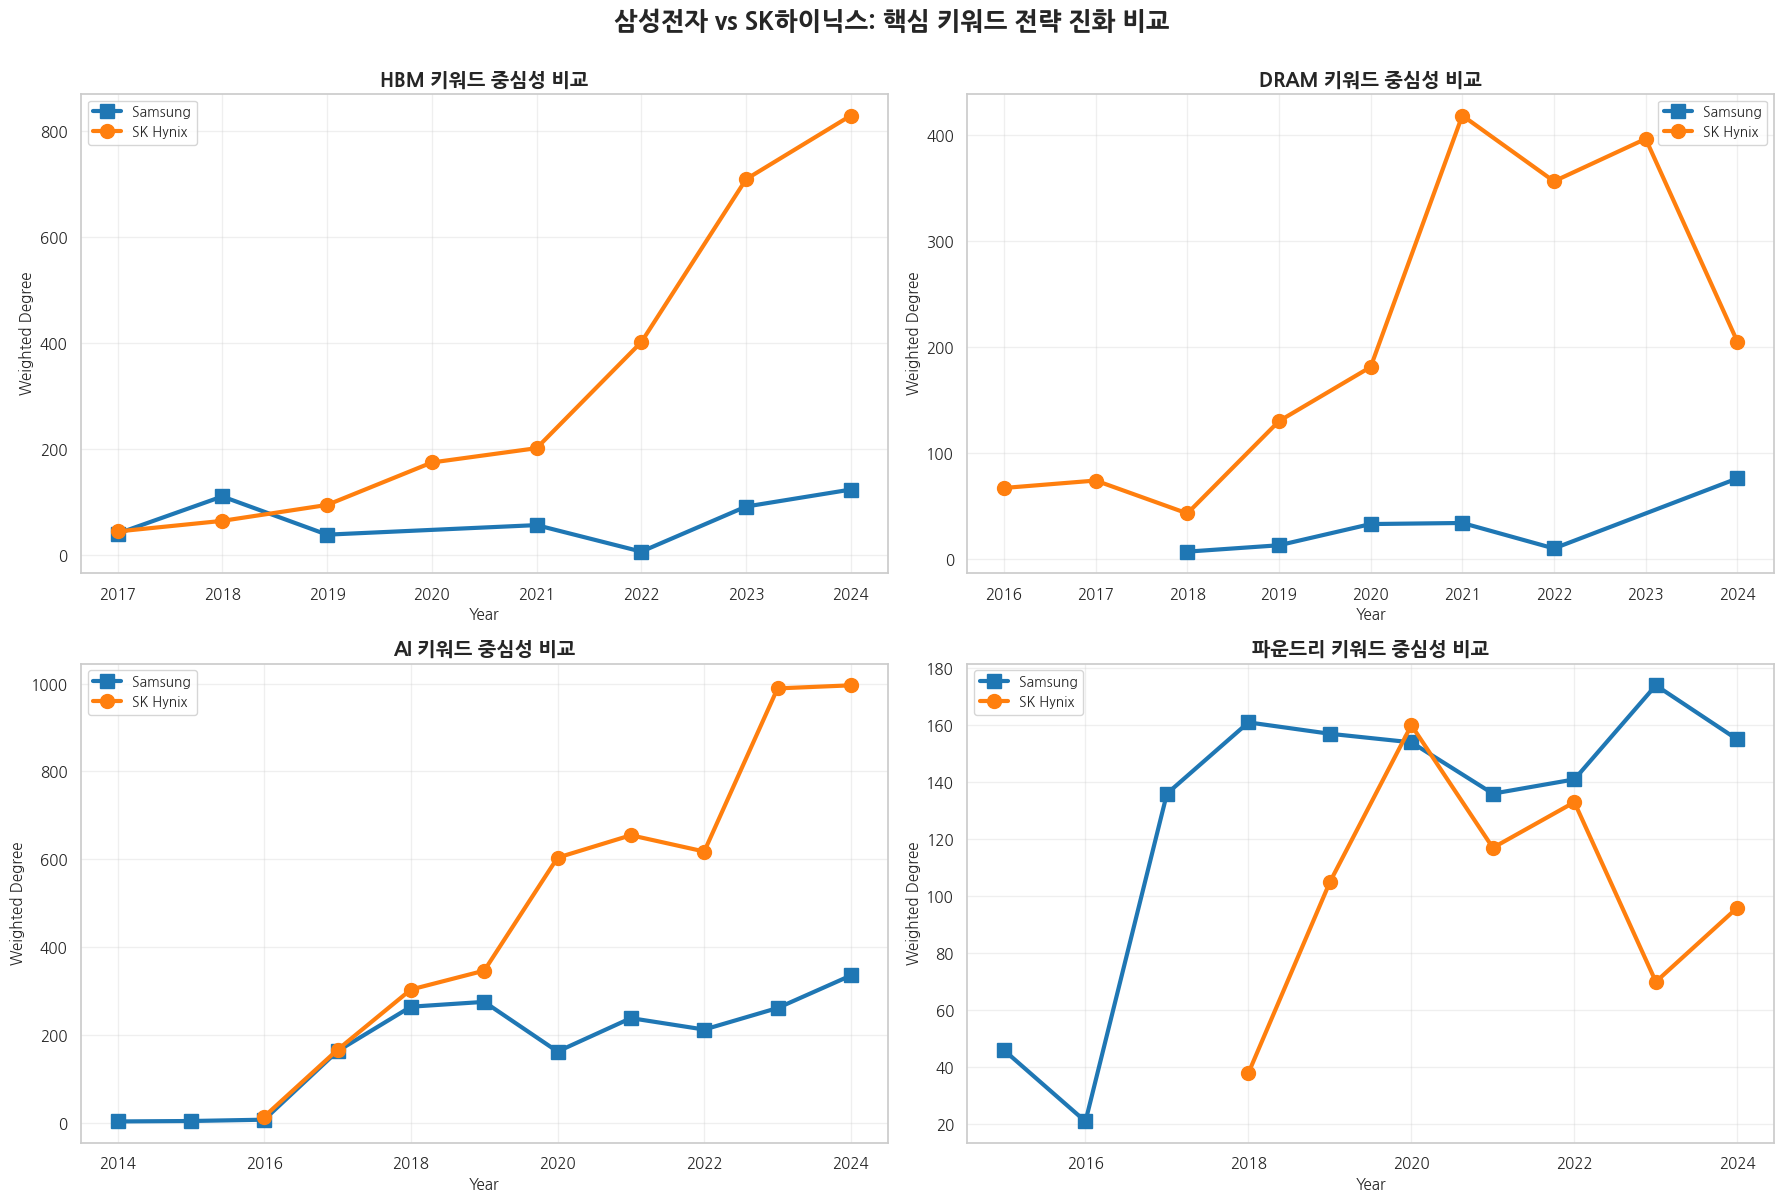

In [8]:
def plot_company_comparison(cent_samsung, cent_skhynix, keywords):
    """삼성전자 vs SK하이닉스의 키워드 중심성 비교"""
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, keyword in enumerate(keywords[:4]):
        ax = axes[idx]
        
        # 삼성 데이터
        sam_data = cent_samsung[cent_samsung['keyword'] == keyword].sort_values('year')
        if len(sam_data) > 0:
            ax.plot(sam_data['year'], sam_data['weighted_degree'], 
                   marker='s', linewidth=3, markersize=10, label='Samsung', color='#1f77b4')
        
        # SK하이닉스 데이터
        sk_data = cent_skhynix[cent_skhynix['keyword'] == keyword].sort_values('year')
        if len(sk_data) > 0:
            ax.plot(sk_data['year'], sk_data['weighted_degree'], 
                   marker='o', linewidth=3, markersize=10, label='SK Hynix', color='#ff7f0e')
        
        ax.set_title(f'{keyword} 키워드 중심성 비교', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=11)
        ax.set_ylabel('Weighted Degree', fontsize=11)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('삼성전자 vs SK하이닉스: 핵심 키워드 전략 진화 비교', 
                fontsize=18, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

comparison_keywords = ['HBM', 'DRAM', 'AI', '파운드리']
plot_company_comparison(centrality_samsung, centrality_skhynix, comparison_keywords)


## 8. 토픽 전환 경로 분석 (Topic Transition)


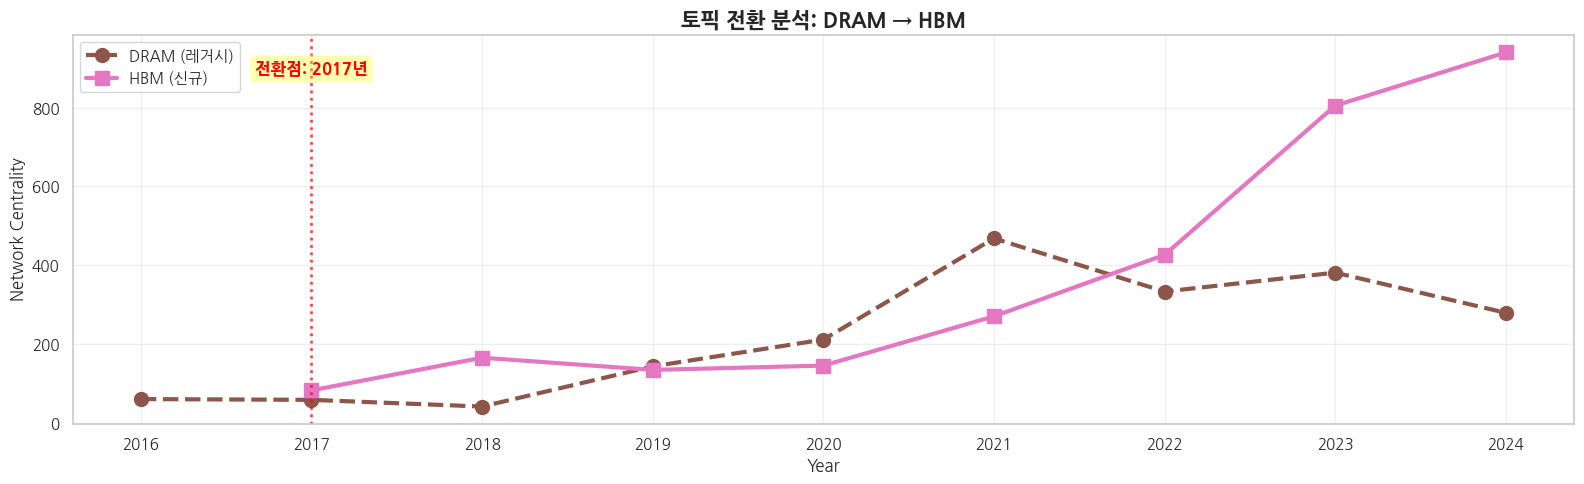

In [9]:
def analyze_topic_transition(df_cent, keyword_pairs):
    """
    특정 키워드 쌍의 중심성 역전 시점 분석
    예: DRAM에서 HBM으로의 전환
    """
    fig, axes = plt.subplots(len(keyword_pairs), 1, figsize=(16, 5*len(keyword_pairs)))
    if len(keyword_pairs) == 1:
        axes = [axes]
    
    for idx, (old_topic, new_topic) in enumerate(keyword_pairs):
        ax = axes[idx]
        
        old_data = df_cent[df_cent['keyword'] == old_topic].sort_values('year')
        new_data = df_cent[df_cent['keyword'] == new_topic].sort_values('year')
        
        if len(old_data) > 0:
            ax.plot(old_data['year'], old_data['weighted_degree'], 
                   marker='o', linewidth=3, markersize=10, label=f'{old_topic} (레거시)', 
                   color='#8c564b', linestyle='--')
        
        if len(new_data) > 0:
            ax.plot(new_data['year'], new_data['weighted_degree'], 
                   marker='s', linewidth=3, markersize=10, label=f'{new_topic} (신규)', 
                   color='#e377c2')
        
        # 교차점 찾기
        if len(old_data) > 0 and len(new_data) > 0:
            merged = pd.merge(old_data[['year', 'weighted_degree']], 
                            new_data[['year', 'weighted_degree']], 
                            on='year', suffixes=('_old', '_new'))
            merged['diff'] = merged['weighted_degree_new'] - merged['weighted_degree_old']
            
            crossover = merged[merged['diff'] > 0]
            if len(crossover) > 0:
                crossover_year = crossover.iloc[0]['year']
                ax.axvline(crossover_year, color='red', linestyle=':', linewidth=2, alpha=0.7)
                ax.text(crossover_year, ax.get_ylim()[1]*0.9, 
                       f'전환점: {int(crossover_year)}년', 
                       ha='center', fontsize=12, color='red', fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        ax.set_title(f'토픽 전환 분석: {old_topic} → {new_topic}', 
                    fontsize=15, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Network Centrality', fontsize=12)
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 주요 토픽 전환 쌍
transition_pairs = [
    ('DRAM', 'HBM'),
]

analyze_topic_transition(centrality_all, transition_pairs)


## 10. 연도별 네트워크 시각화 (Small Multiples)


=== Samsung Electronics Yearly Networks ===
Saved: ../reports/Figure/fig_12_temporal_network_Samsung.png


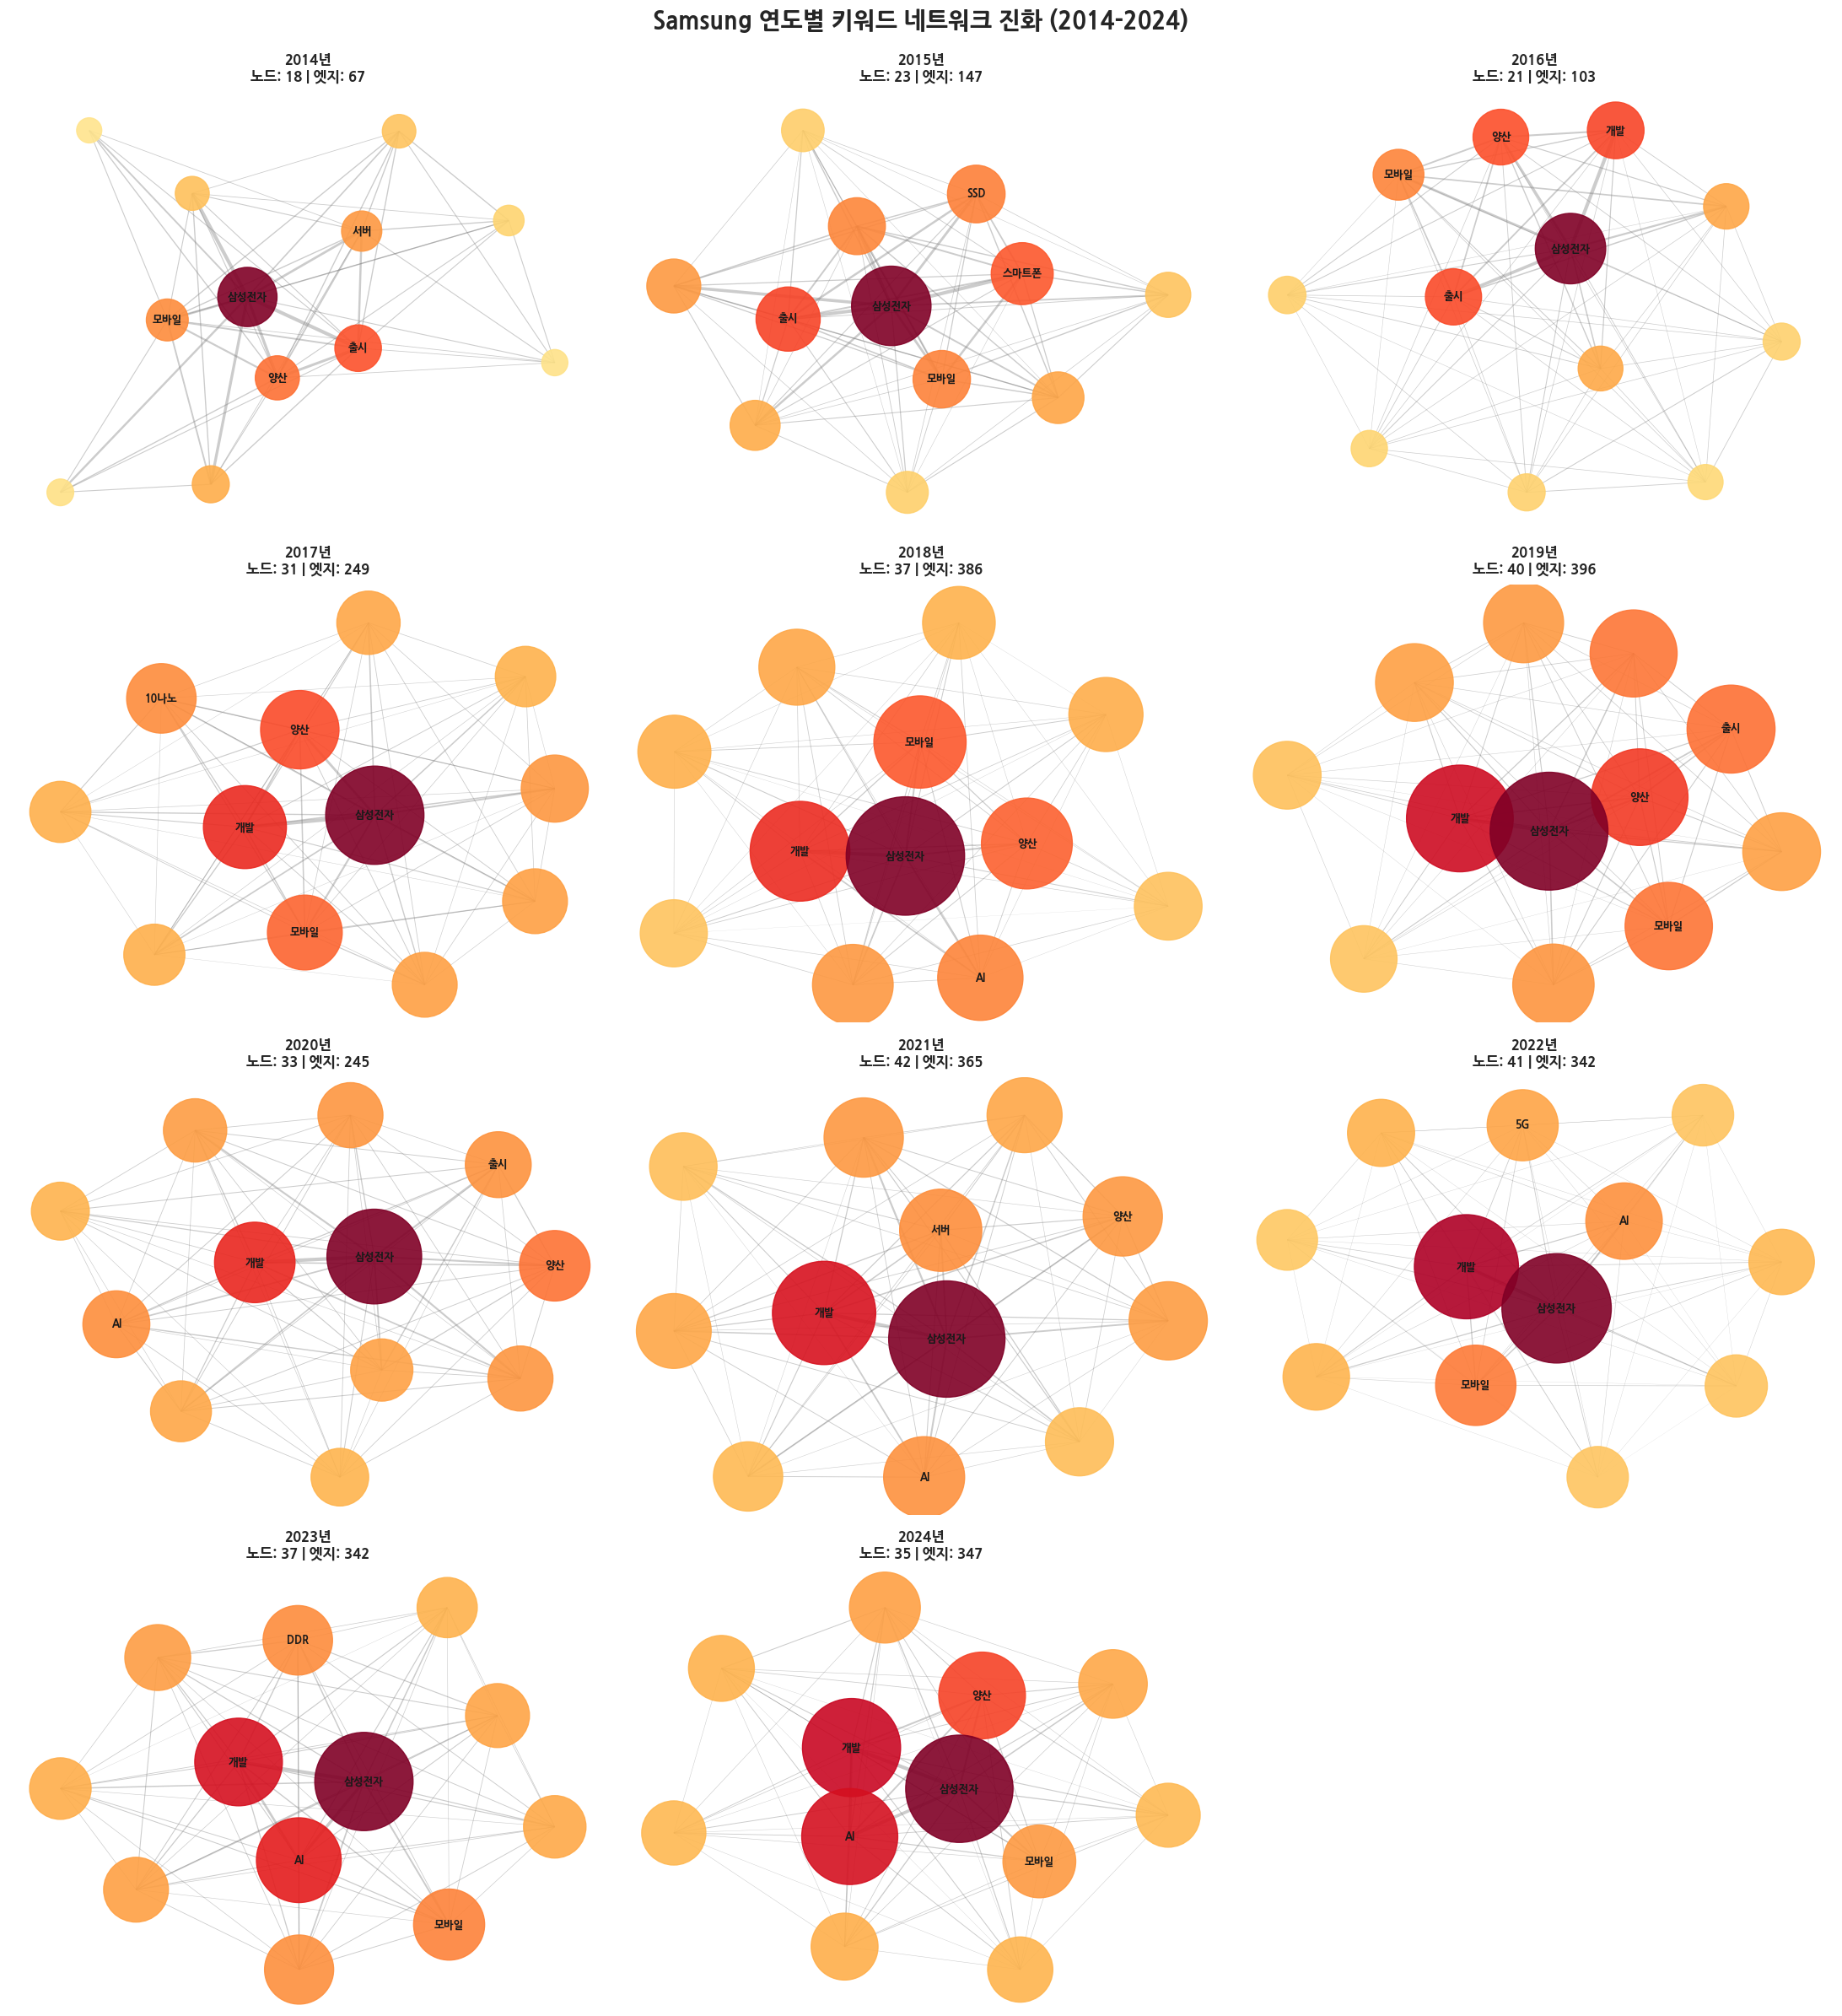


=== SK Hynix Yearly Networks ===
Saved: ../reports/Figure/fig_12_temporal_network_SKHynix.png


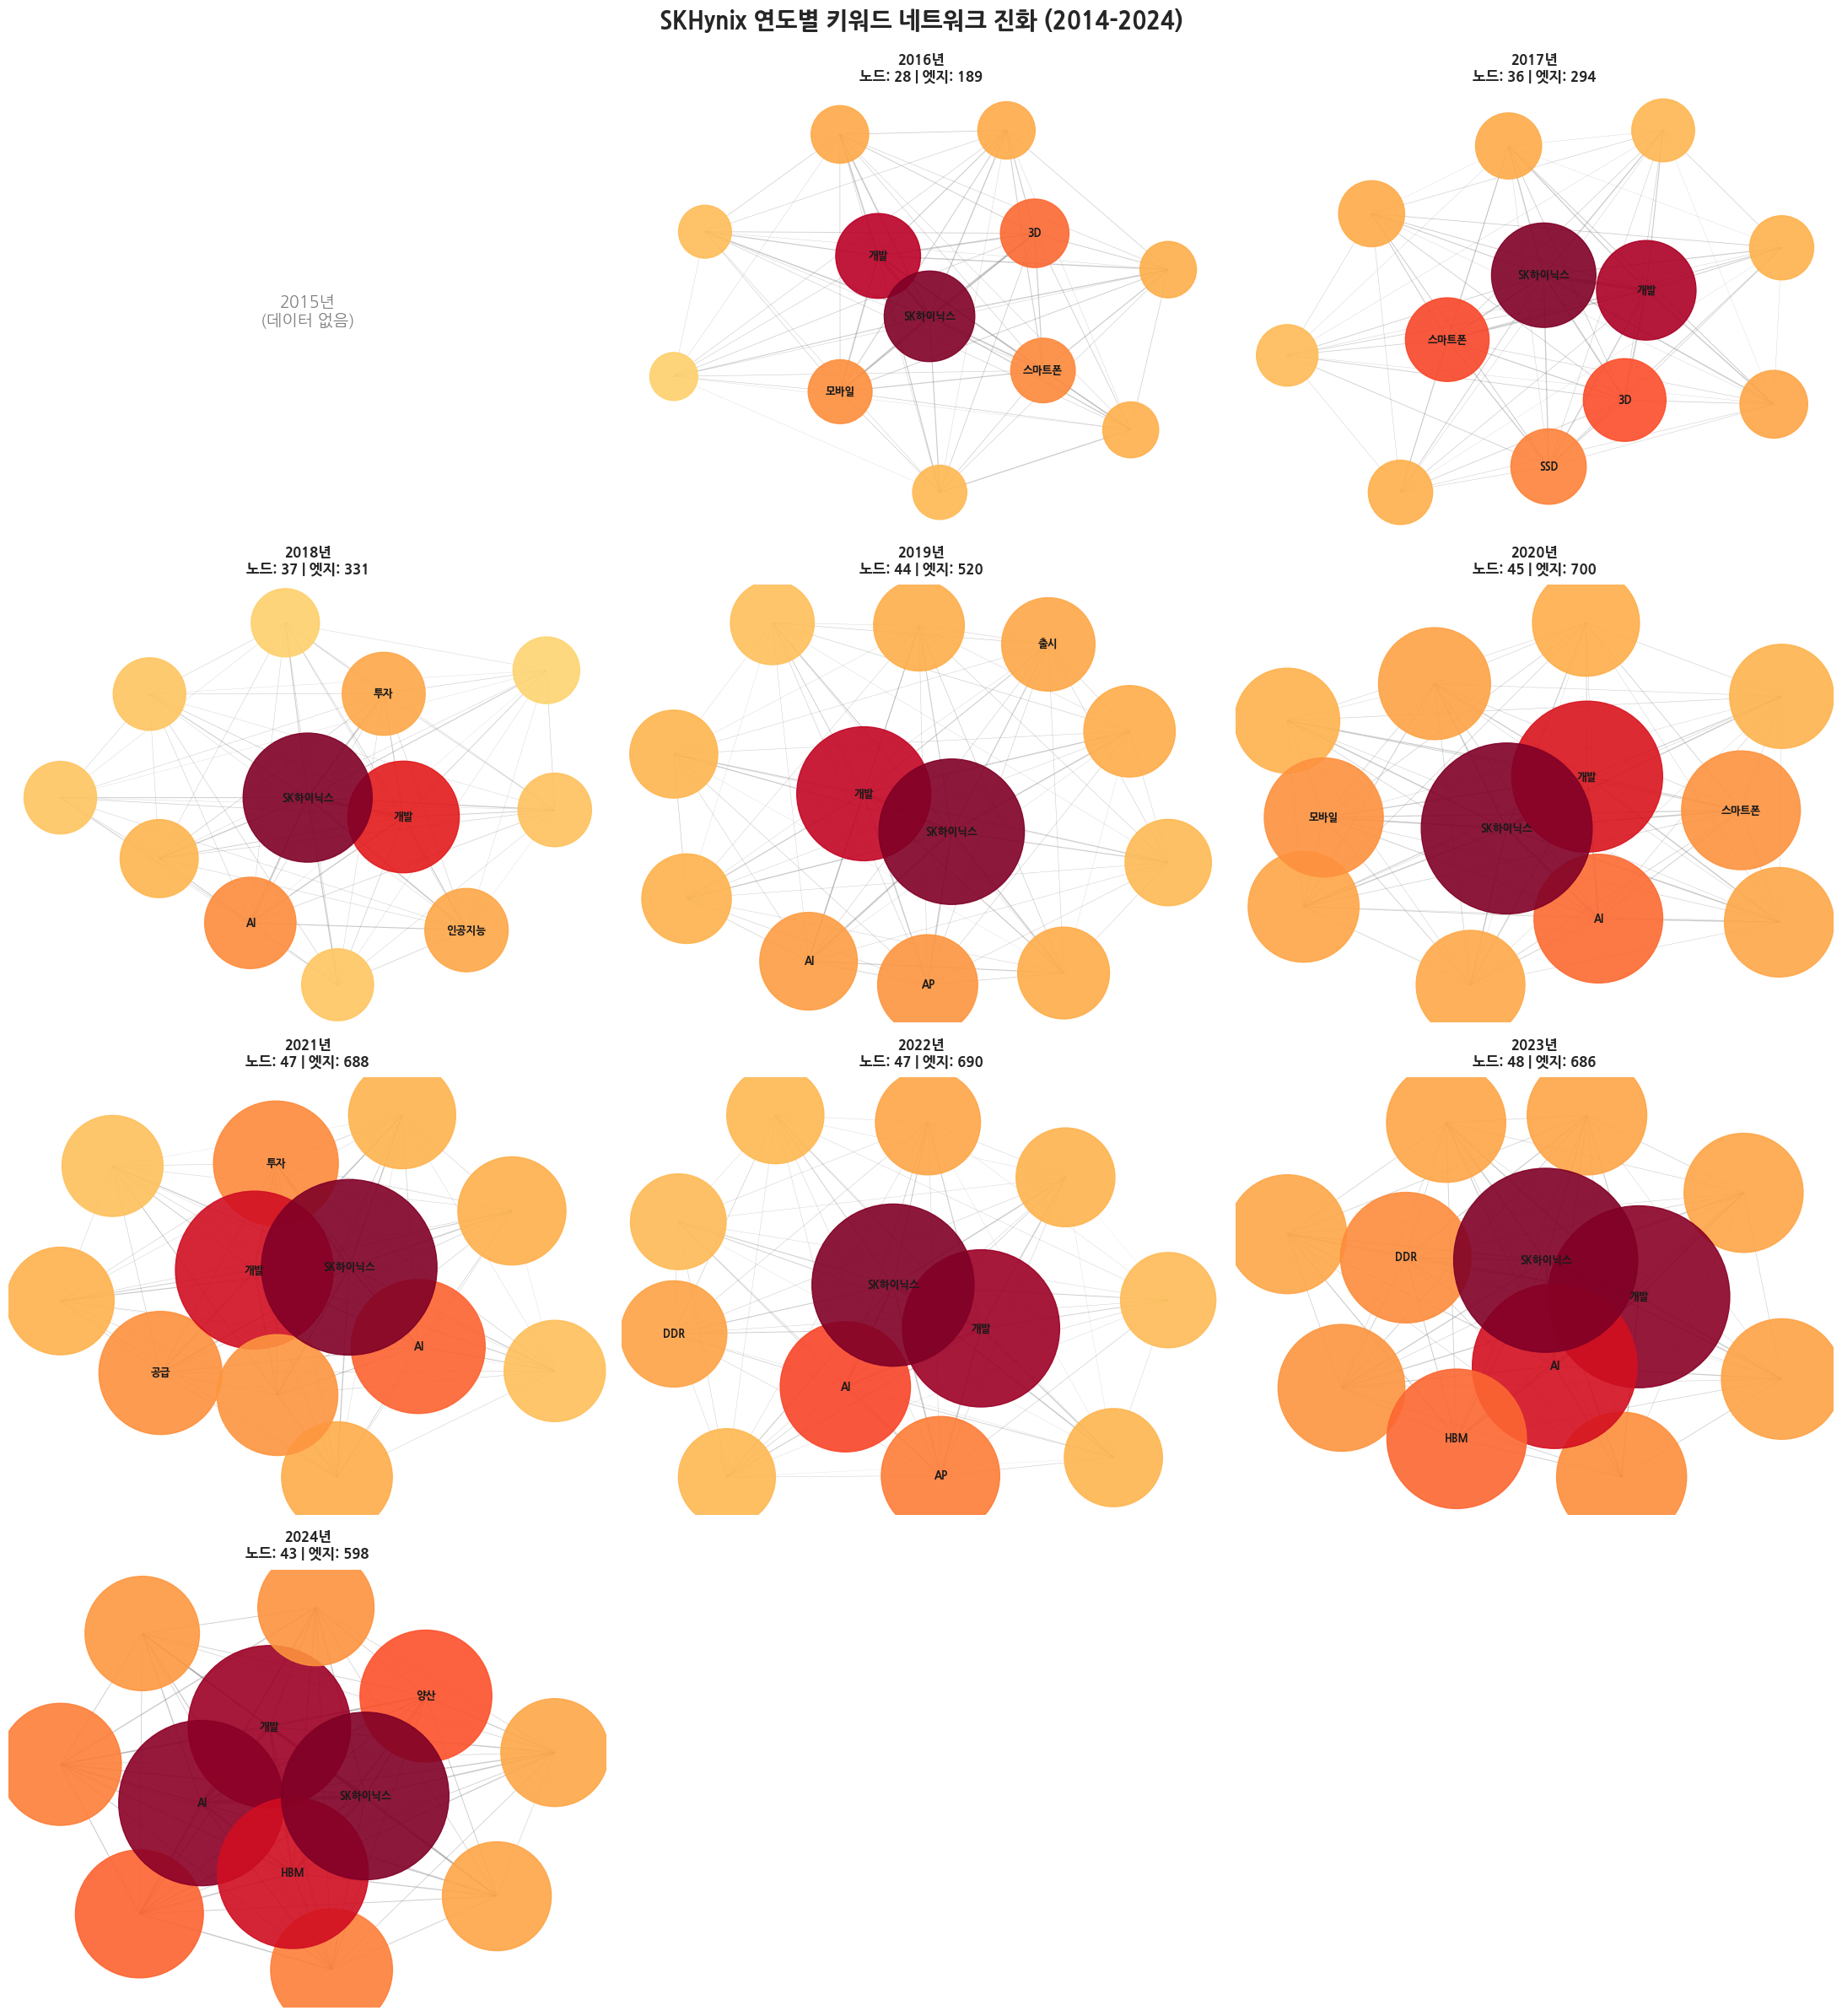

In [10]:
def plot_temporal_networks_by_company(networks_dict, company_name, years_to_plot=None, top_nodes=15):
    """
    특정 회사의 연도별 네트워크를 Small Multiples로 시각화
    
    Parameters:
    - networks_dict: 연도별 네트워크 딕셔너리
    - company_name: 회사명 (표시용)
    - years_to_plot: 시각화할 연도 리스트 (None이면 전체)
    - top_nodes: 각 네트워크에서 표시할 최대 노드 수
    """
    if years_to_plot is None:
        years_to_plot = sorted(networks_dict.keys())
    
    n_years = len(years_to_plot)
    n_cols = 3
    n_rows = (n_years + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 6*n_rows))
    axes = axes.flatten() if n_years > 1 else [axes]
    
    for idx, year in enumerate(years_to_plot):
        ax = axes[idx]
        G = networks_dict[year]
        
        if G.number_of_nodes() == 0:
            ax.text(0.5, 0.5, f'{year}년\n(데이터 없음)', 
                   ha='center', va='center', fontsize=14, color='gray')
            ax.axis('off')
            continue
        
        # 상위 노드만 선택 (Weighted Degree 기준)
        degree_dict = dict(G.degree(weight='weight'))
        top_nodes_list = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:top_nodes]
        top_node_names = [node for node, _ in top_nodes_list]
        
        # 서브그래프 생성
        G_sub = G.subgraph(top_node_names).copy()
        
        # 레이아웃 (Spring layout)
        pos = nx.spring_layout(G_sub, k=1.0, iterations=50, seed=42)
        
        # 노드 크기 (degree에 비례)
        node_sizes = [degree_dict[node] * 20 for node in G_sub.nodes()]
        
        # 노드 색상 (중심성에 따라)
        node_colors = [degree_dict[node] for node in G_sub.nodes()]
        
        # 엣지 두께 (weight에 비례)
        edges = G_sub.edges()
        weights = [G_sub[u][v]['weight'] for u, v in edges]
        max_weight = max(weights) if weights else 1
        edge_widths = [w / max_weight * 3 for w in weights]
        
        # 네트워크 그리기
        nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, 
                              node_color=node_colors, cmap='YlOrRd',
                              alpha=0.9, ax=ax, vmin=0, vmax=max(node_colors) if node_colors else 1)
        
        nx.draw_networkx_edges(G_sub, pos, width=edge_widths, 
                              alpha=0.4, edge_color='gray', ax=ax)
        
        # 레이블 (주요 노드만)
        top_5_nodes = [node for node, _ in top_nodes_list[:5]]
        labels = {node: node for node in G_sub.nodes() if node in top_5_nodes}
        nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=9, 
                               font_weight='bold', font_family='NanumGothic', ax=ax)
        
        # 제목
        ax.set_title(f'{year}년\n노드: {G.number_of_nodes()} | 엣지: {G.number_of_edges()}', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
    
    # 남은 빈 서브플롯 제거
    for idx in range(n_years, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{company_name} 연도별 키워드 네트워크 진화 (2014-2024)', 
                fontsize=20, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # 저장
    save_path = os.path.join(OUTPUT_DIR, f'fig_12_temporal_network_{company_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    
    plt.show()

# 삼성전자 연도별 네트워크
print("=== Samsung Electronics Yearly Networks ===")
plot_temporal_networks_by_company(networks_samsung, "Samsung", top_nodes=12)

# SK하이닉스 연도별 네트워크
print("\n=== SK Hynix Yearly Networks ===")
plot_temporal_networks_by_company(networks_skhynix, "SKHynix", top_nodes=12)


## 11. 연도별 키워드 워드클라우드 (Word Cloud Style)


=== Samsung Electronics Yearly Word Clouds ===
Saved: ../reports/Figure/fig_13_wordcloud_Samsung.png


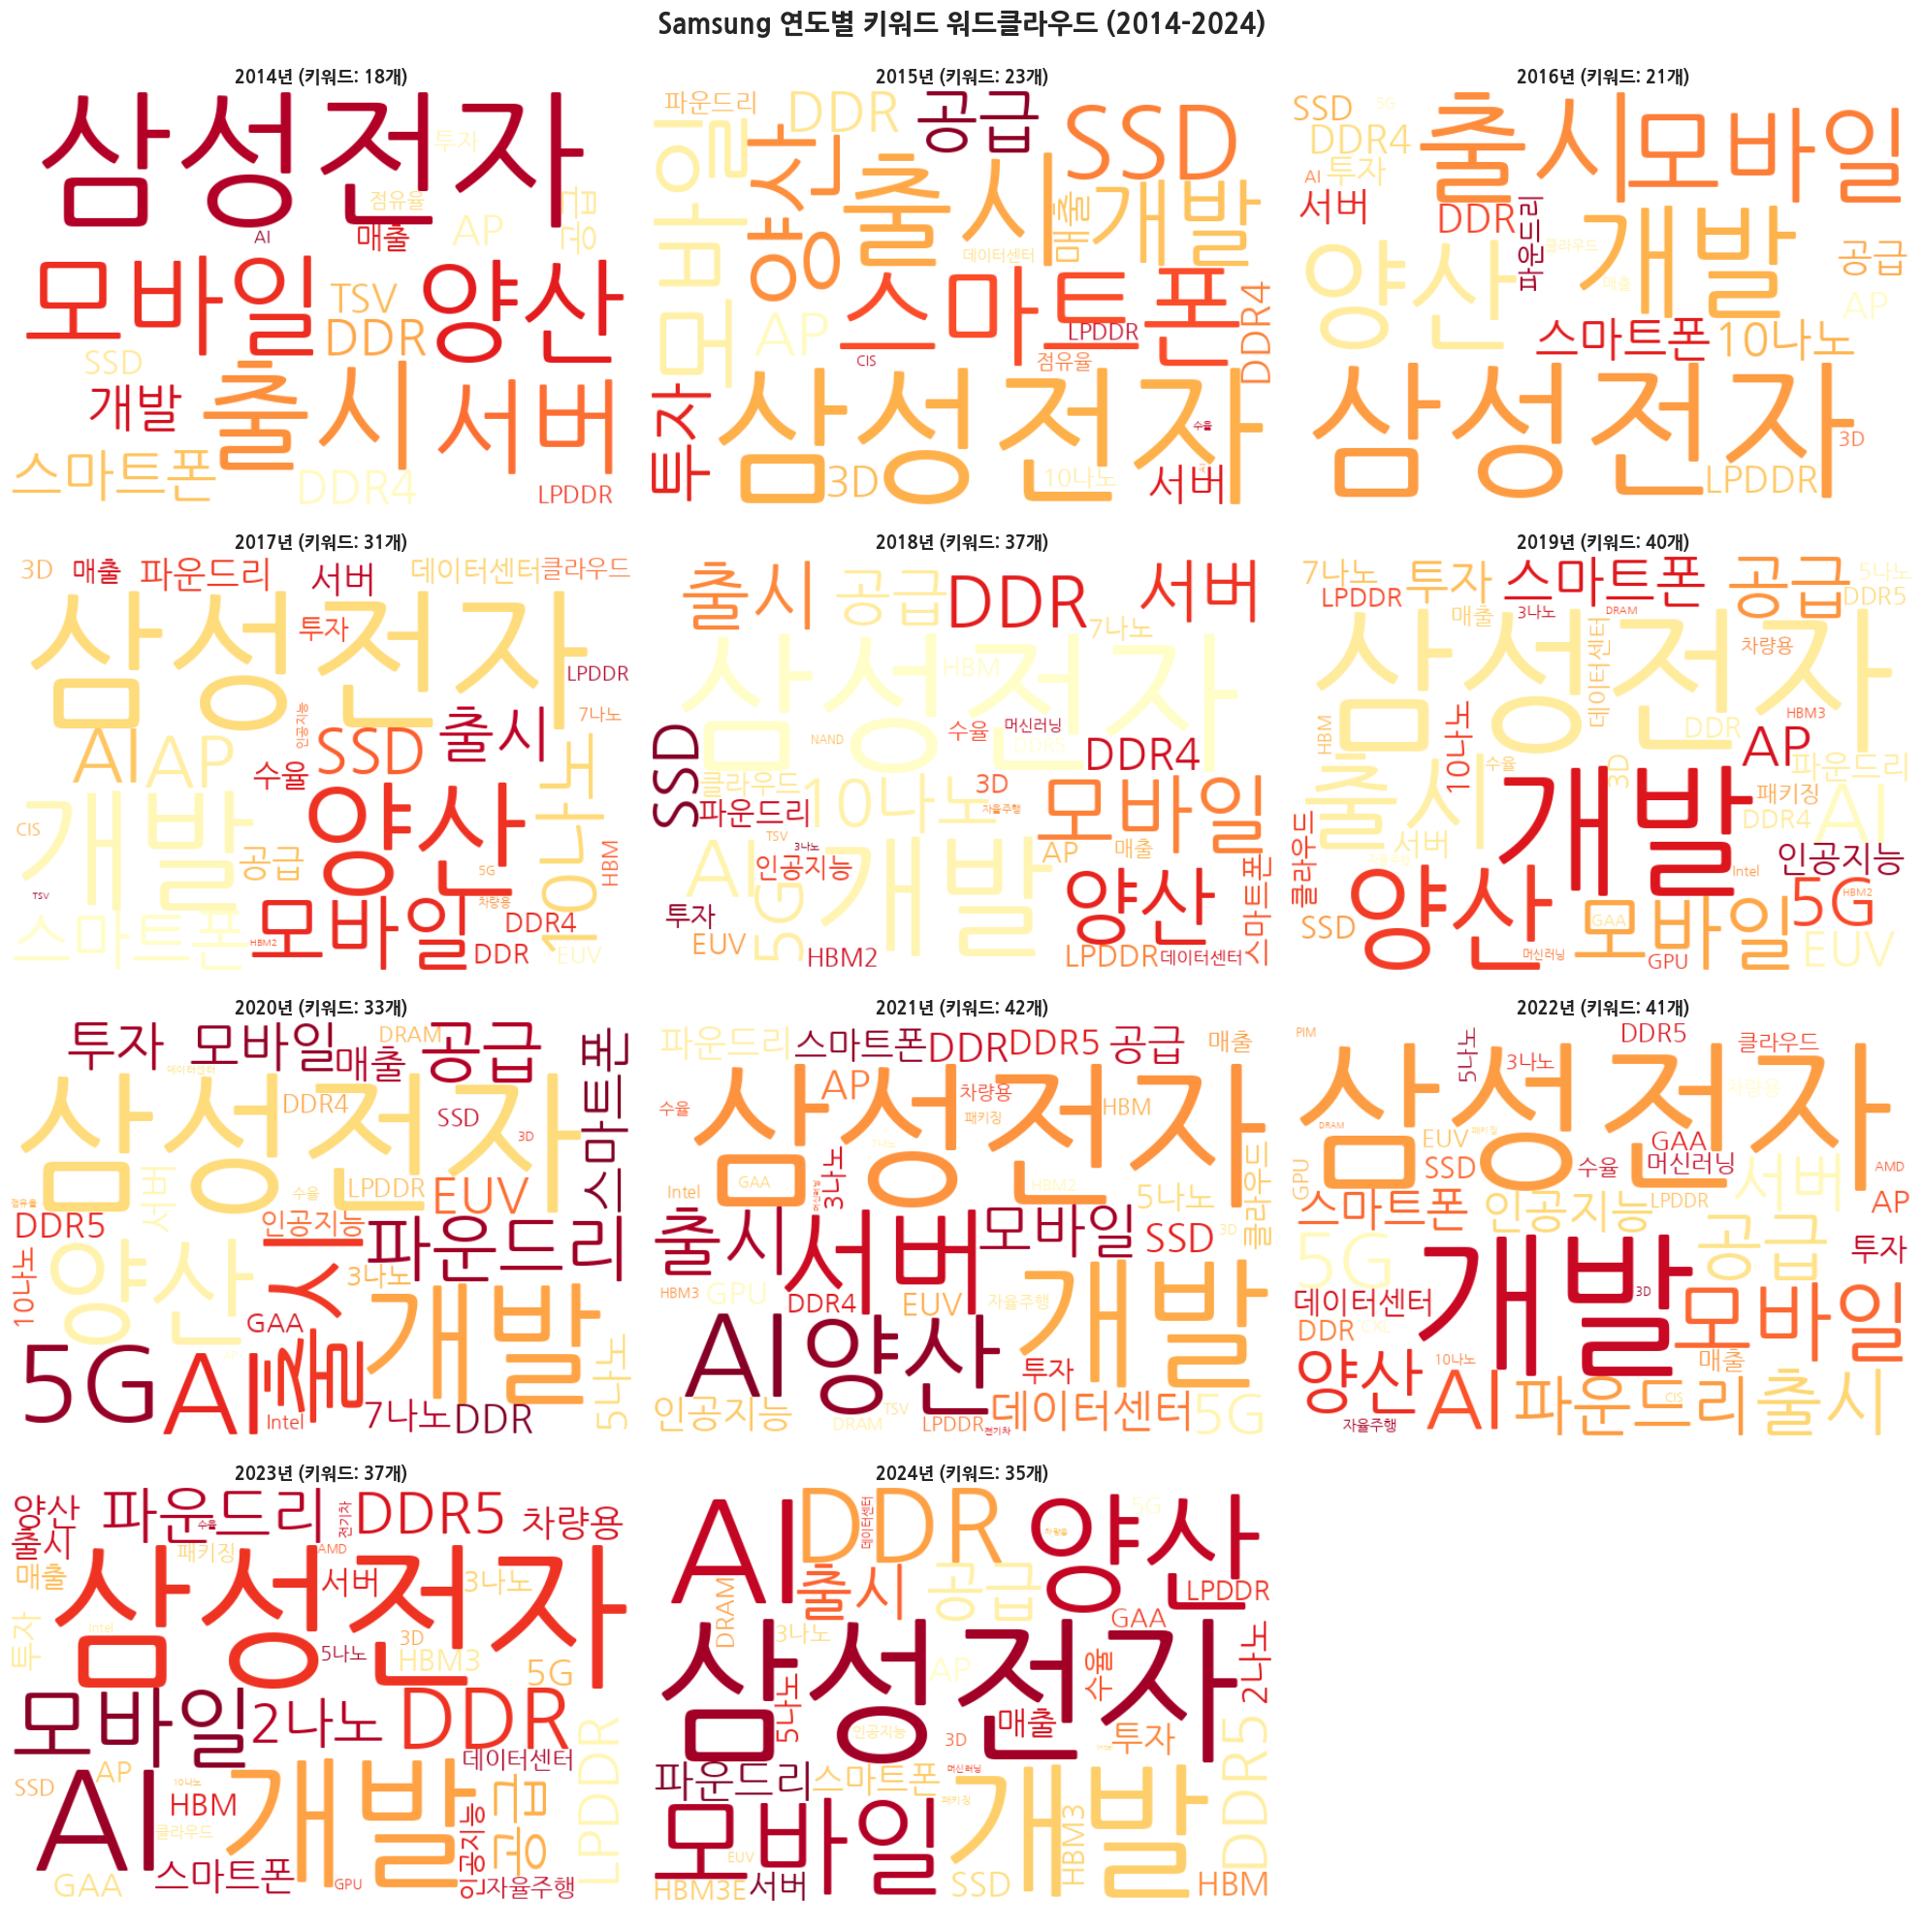


=== SK Hynix Yearly Word Clouds ===
Saved: ../reports/Figure/fig_13_wordcloud_SKHynix.png


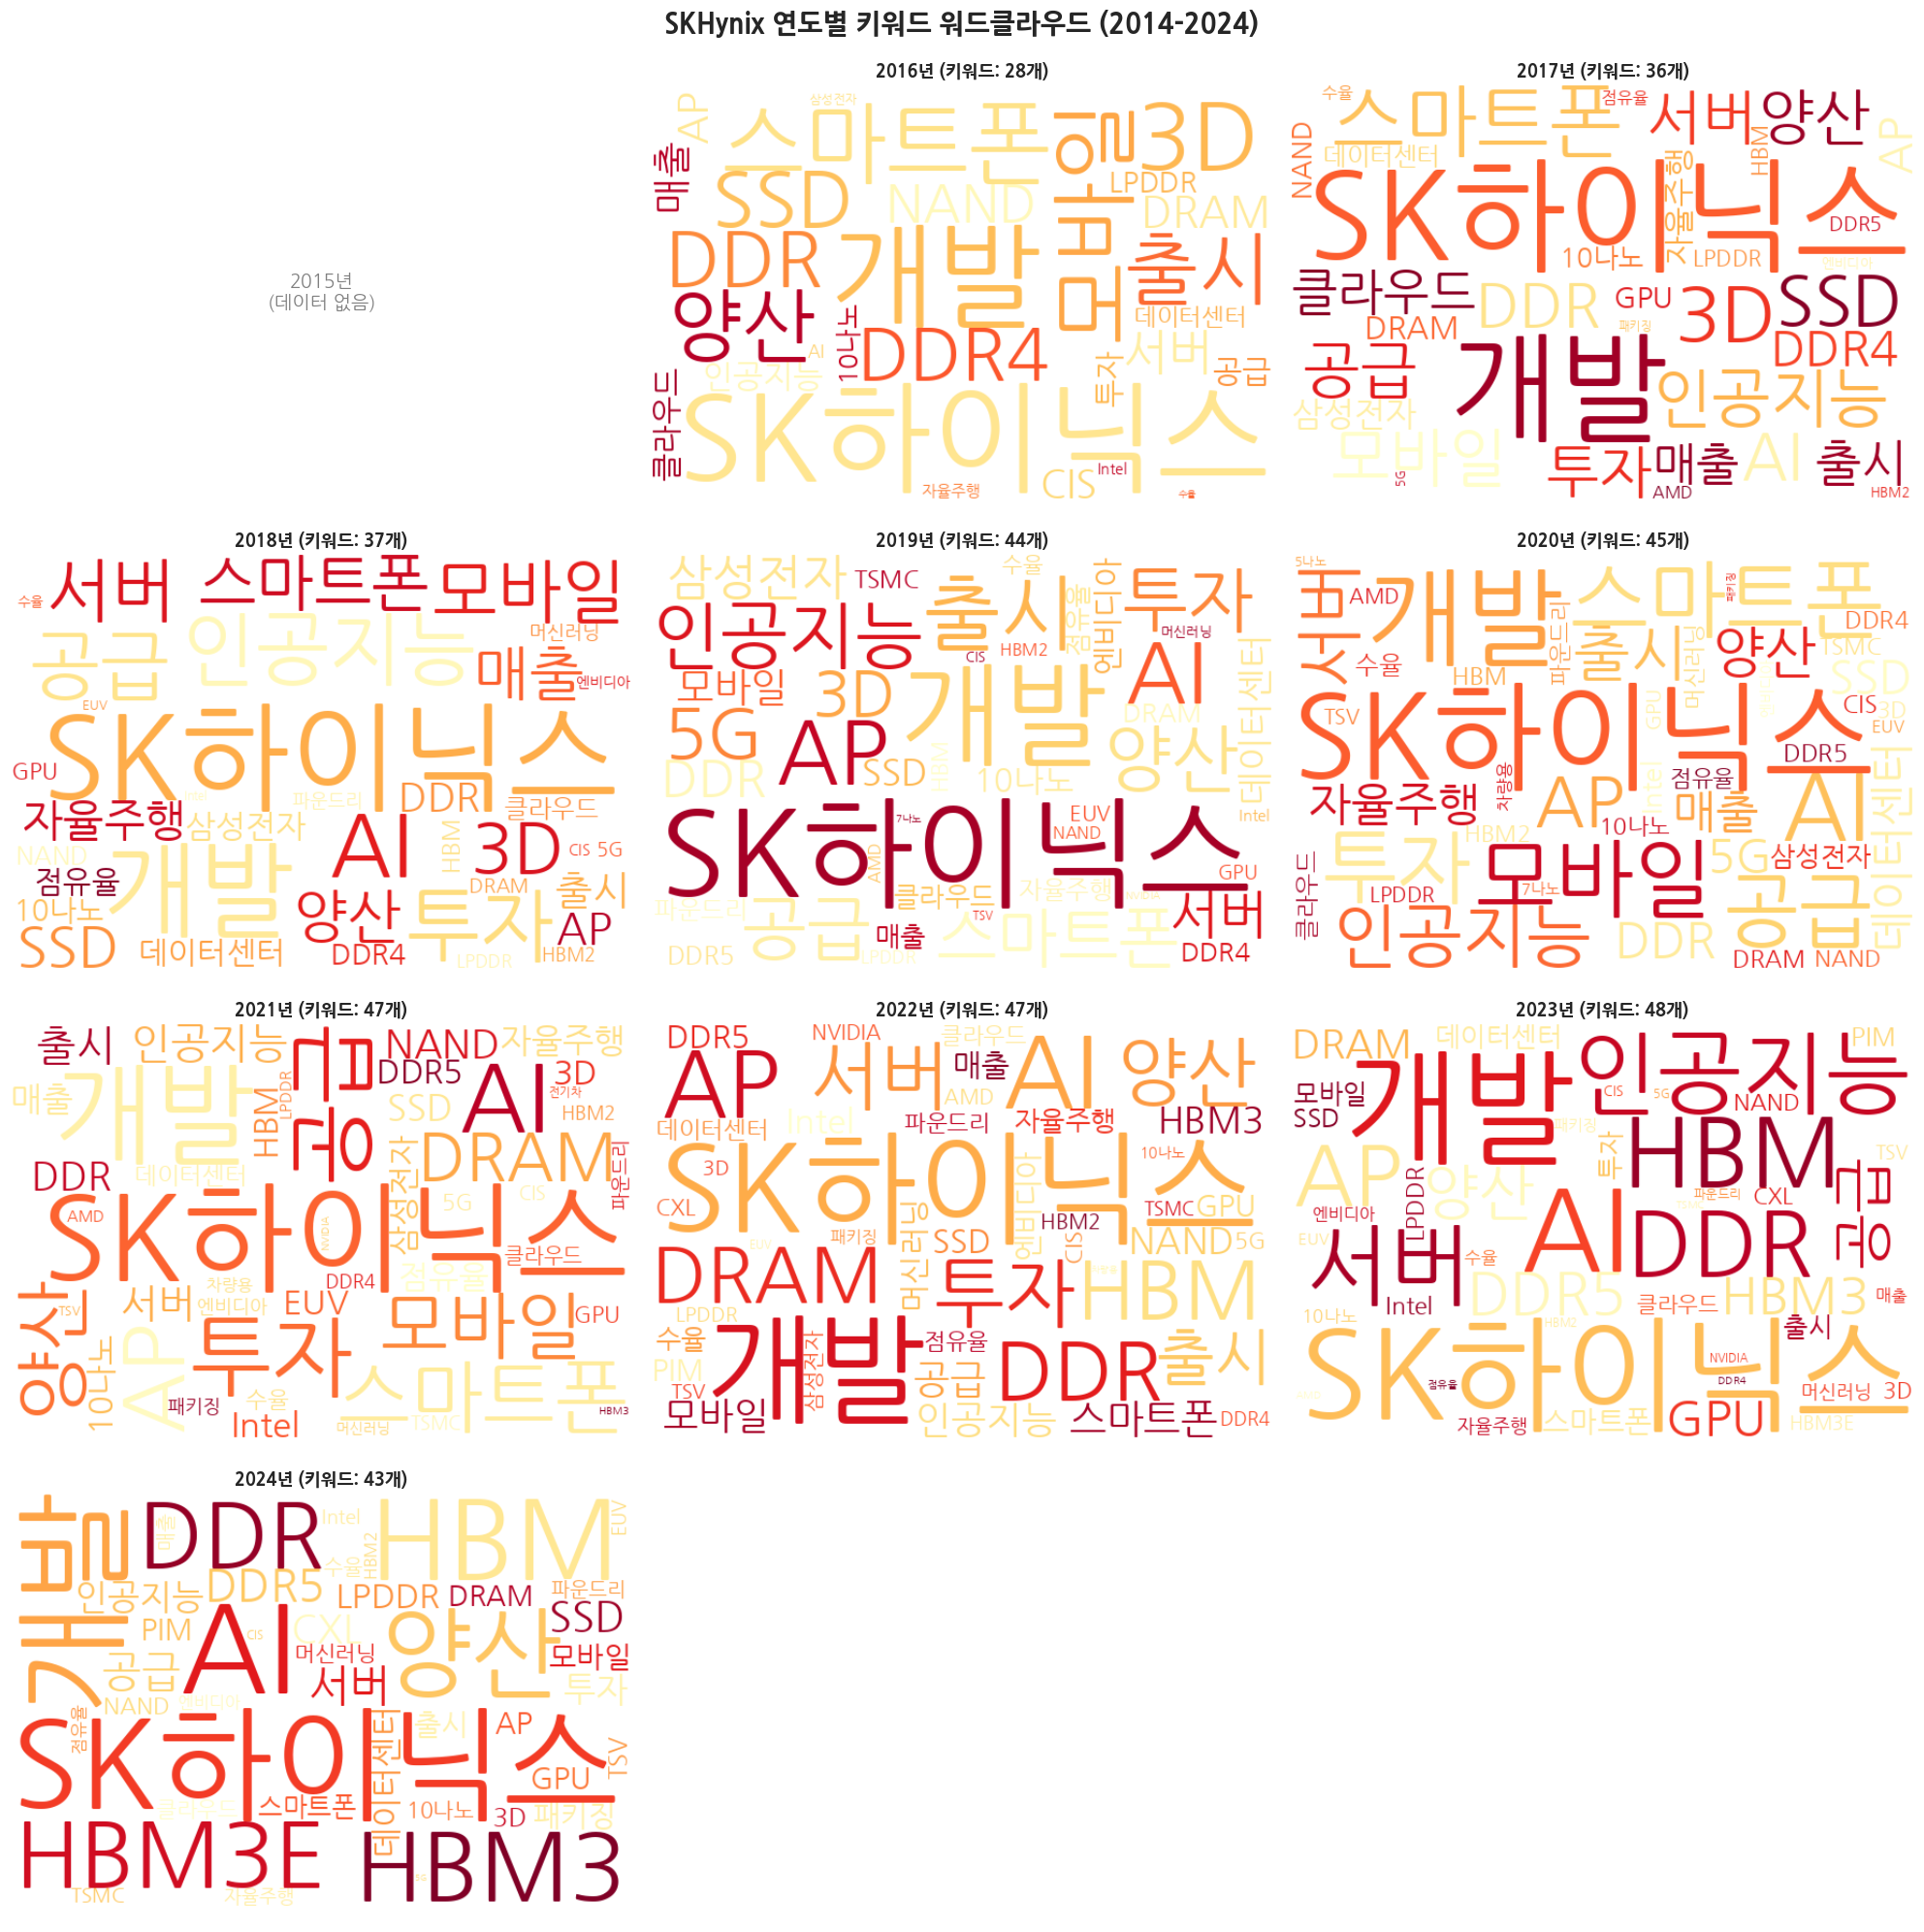

In [11]:
def plot_wordcloud_by_year(networks_dict, company_name, years_to_plot=None):
    """
    연도별 키워드를 워드클라우드 스타일로 시각화
    키워드 크기 = 네트워크 중심성(Weighted Degree)
    """
    from wordcloud import WordCloud
    
    if years_to_plot is None:
        years_to_plot = sorted(networks_dict.keys())
    
    n_years = len(years_to_plot)
    n_cols = 3
    n_rows = (n_years + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_years > 1 else [axes]
    
    for idx, year in enumerate(years_to_plot):
        ax = axes[idx]
        G = networks_dict[year]
        
        if G.number_of_nodes() == 0:
            ax.text(0.5, 0.5, f'{year}년\n(데이터 없음)', 
                   ha='center', va='center', fontsize=14, color='gray')
            ax.axis('off')
            continue
        
        # Weighted Degree를 단어 빈도처럼 사용
        degree_dict = dict(G.degree(weight='weight'))
        
        # WordCloud 생성
        try:
            wc = WordCloud(
                width=600, 
                height=400,
                background_color='white',
                colormap='YlOrRd',
                font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                relative_scaling=0.5,
                min_font_size=8
            ).generate_from_frequencies(degree_dict)
            
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(f'{year}년 (키워드: {G.number_of_nodes()}개)', 
                        fontsize=13, fontweight='bold')
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f'{year}년\n워드클라우드 생성 실패', 
                   ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')
    
    # 남은 빈 서브플롯 제거
    for idx in range(n_years, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{company_name} 연도별 키워드 워드클라우드 (2014-2024)', 
                fontsize=20, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # 저장
    save_path = os.path.join(OUTPUT_DIR, f'fig_13_wordcloud_{company_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    
    plt.show()

# 삼성전자 워드클라우드
print("=== Samsung Electronics Yearly Word Clouds ===")
plot_wordcloud_by_year(networks_samsung, "Samsung")

# SK하이닉스 워드클라우드
print("\n=== SK Hynix Yearly Word Clouds ===")
plot_wordcloud_by_year(networks_skhynix, "SKHynix")


## 12. 특정 연도 비교 (Side-by-Side)


=== Comparing Networks for Key Years: [2016, 2019, 2022, 2024] ===
Saved: ../reports/Figure/fig_14_network_comparison_by_year.png


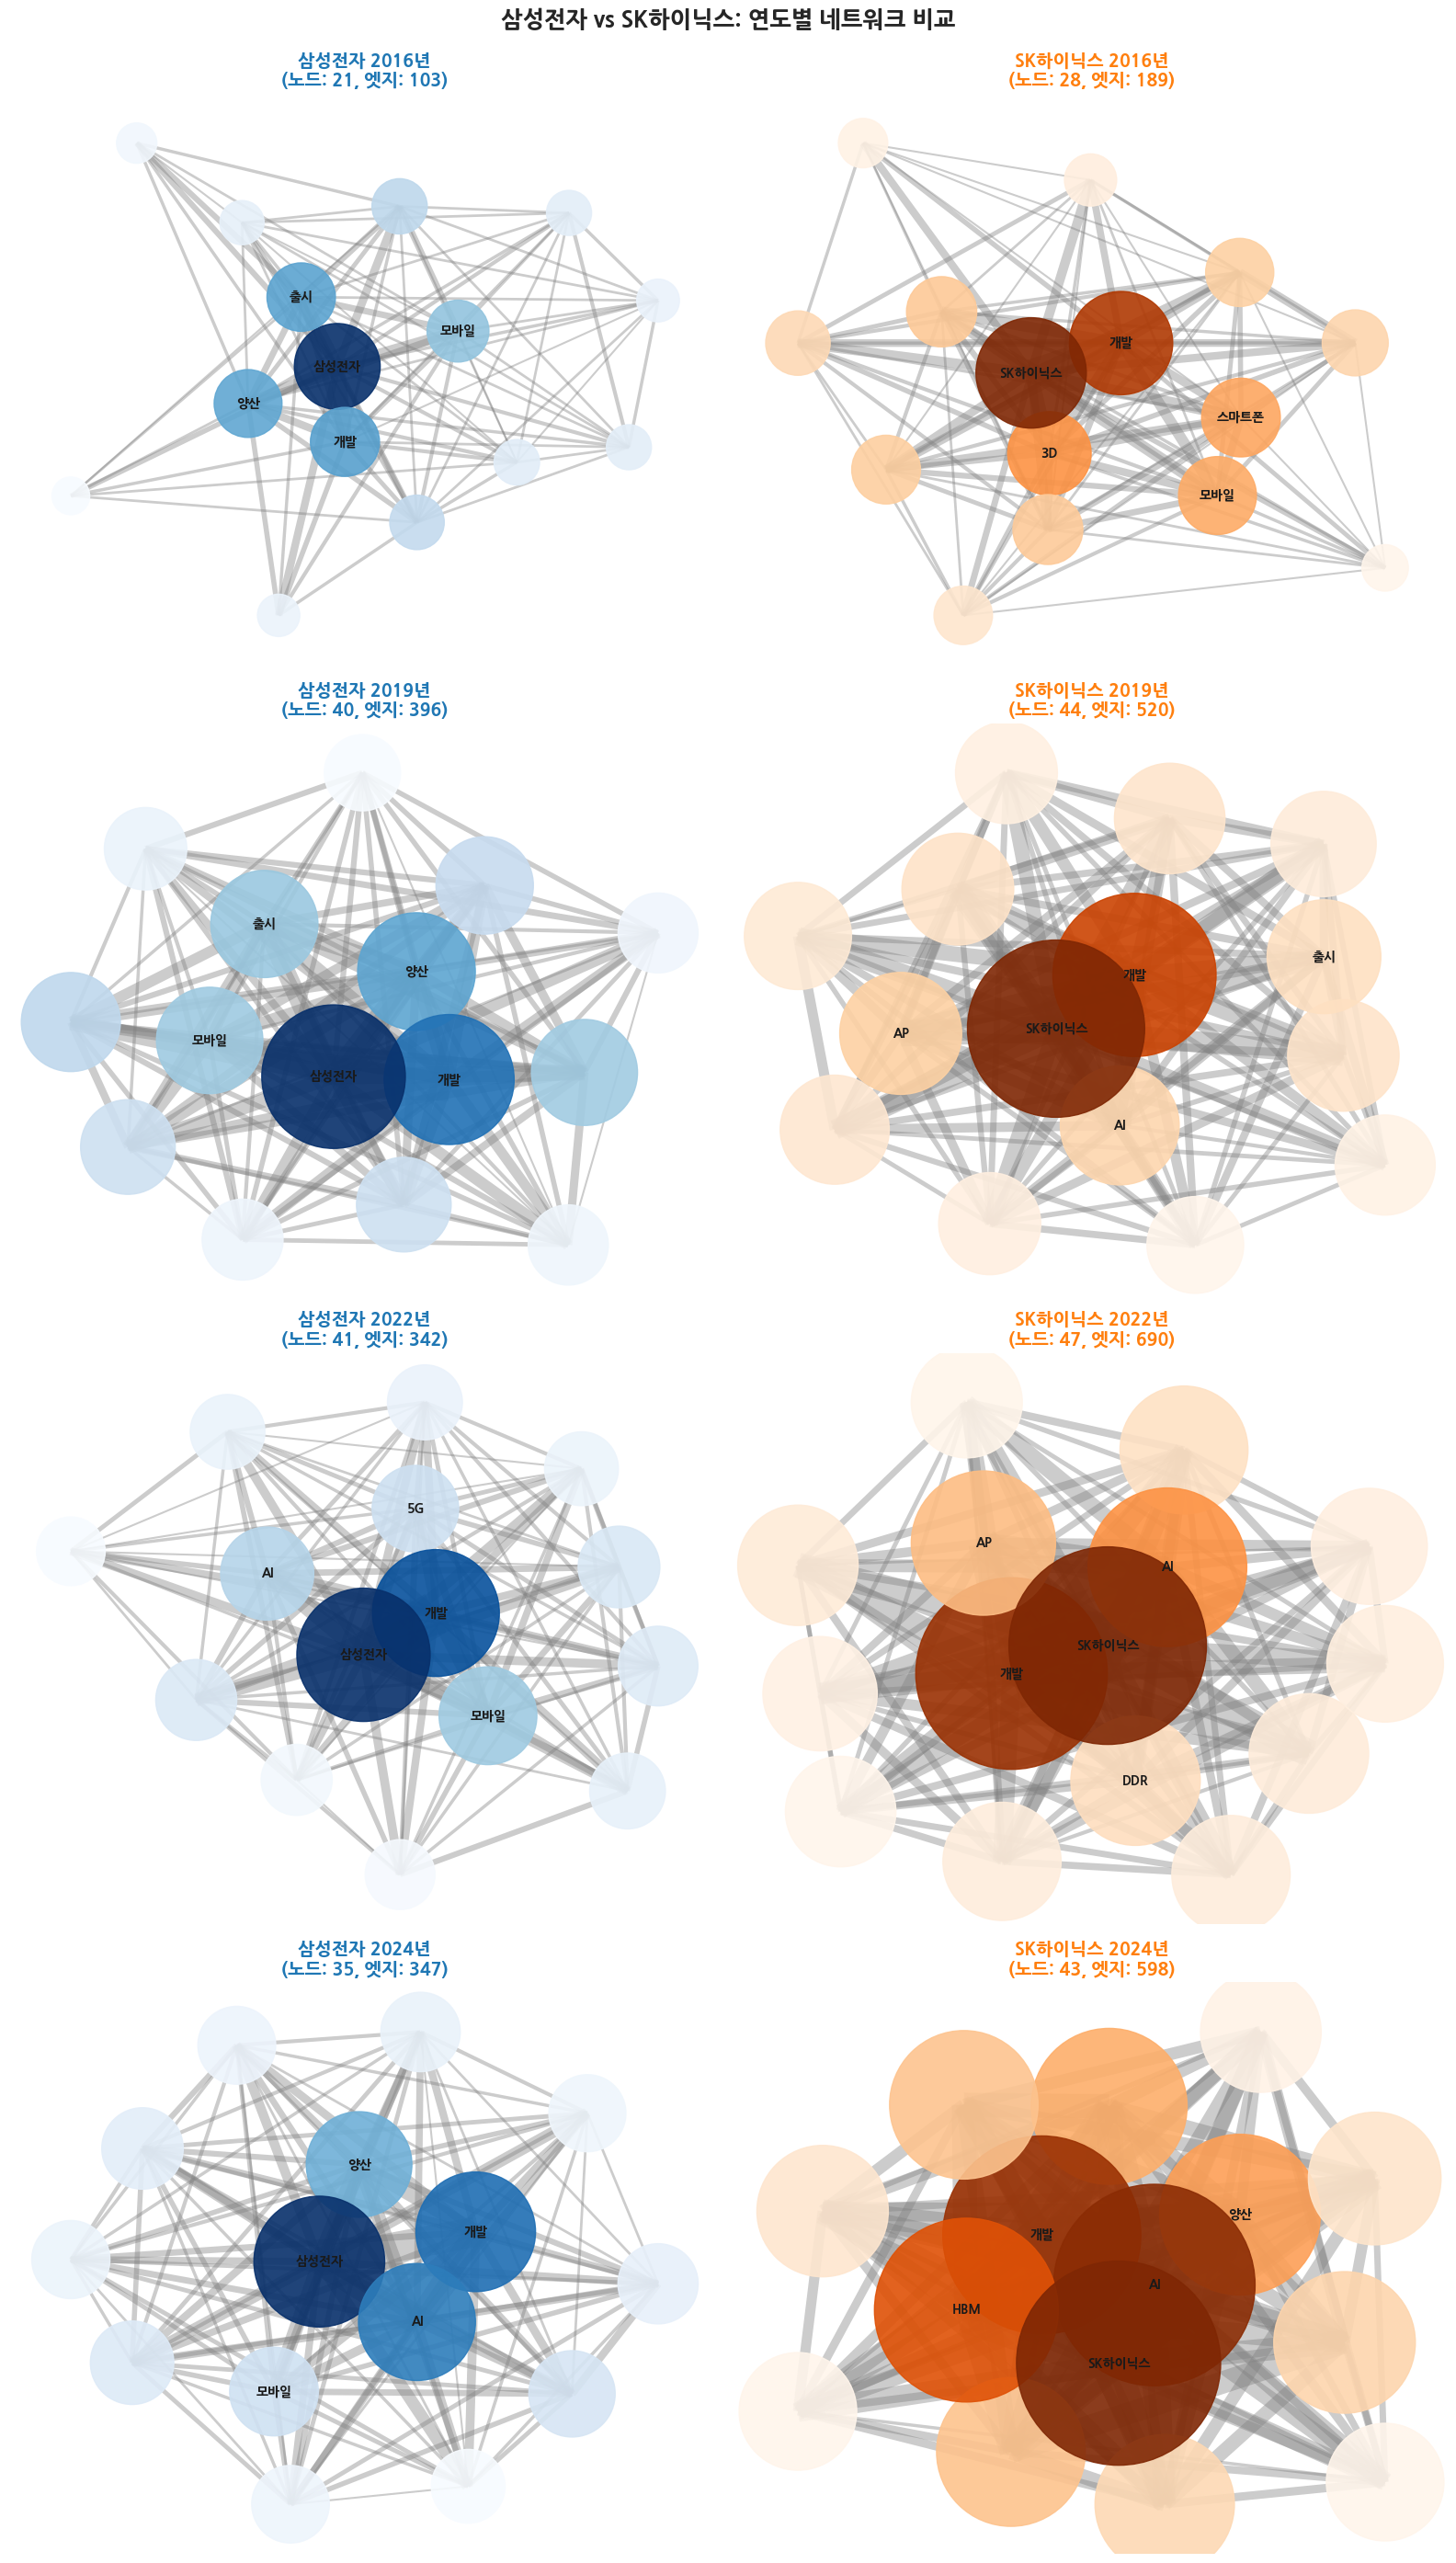

In [12]:
def compare_networks_by_year(networks_samsung, networks_skhynix, years_to_compare):
    """
    특정 연도들에 대해 삼성 vs SK하이닉스 네트워크를 나란히 비교
    """
    n_years = len(years_to_compare)
    fig, axes = plt.subplots(n_years, 2, figsize=(16, 7*n_years))
    
    if n_years == 1:
        axes = axes.reshape(1, -1)
    
    for idx, year in enumerate(years_to_compare):
        # 삼성 네트워크
        ax_sam = axes[idx, 0]
        G_sam = networks_samsung.get(year, nx.Graph())
        
        if G_sam.number_of_nodes() > 0:
            degree_dict_sam = dict(G_sam.degree(weight='weight'))
            top_nodes_sam = sorted(degree_dict_sam.items(), key=lambda x: x[1], reverse=True)[:15]
            top_node_names_sam = [node for node, _ in top_nodes_sam]
            
            G_sub_sam = G_sam.subgraph(top_node_names_sam).copy()
            pos_sam = nx.spring_layout(G_sub_sam, k=1.0, iterations=50, seed=42)
            
            node_sizes_sam = [degree_dict_sam[node] * 25 for node in G_sub_sam.nodes()]
            node_colors_sam = [degree_dict_sam[node] for node in G_sub_sam.nodes()]
            
            edges_sam = G_sub_sam.edges()
            weights_sam = [G_sub_sam[u][v]['weight'] for u, v in edges_sam]
            edge_widths_sam = [w * 0.5 for w in weights_sam]
            
            nx.draw_networkx_nodes(G_sub_sam, pos_sam, node_size=node_sizes_sam,
                                  node_color=node_colors_sam, cmap='Blues',
                                  alpha=0.9, ax=ax_sam)
            nx.draw_networkx_edges(G_sub_sam, pos_sam, width=edge_widths_sam,
                                  alpha=0.4, edge_color='gray', ax=ax_sam)
            
            top_5_sam = [node for node, _ in top_nodes_sam[:5]]
            labels_sam = {node: node for node in G_sub_sam.nodes() if node in top_5_sam}
            nx.draw_networkx_labels(G_sub_sam, pos_sam, labels=labels_sam,
                                   font_size=10, font_weight='bold', 
                                   font_family='NanumGothic', ax=ax_sam)
        
        ax_sam.set_title(f'삼성전자 {year}년\n(노드: {G_sam.number_of_nodes()}, 엣지: {G_sam.number_of_edges()})',
                        fontsize=14, fontweight='bold', color='#1f77b4')
        ax_sam.axis('off')
        
        # SK하이닉스 네트워크
        ax_sk = axes[idx, 1]
        G_sk = networks_skhynix.get(year, nx.Graph())
        
        if G_sk.number_of_nodes() > 0:
            degree_dict_sk = dict(G_sk.degree(weight='weight'))
            top_nodes_sk = sorted(degree_dict_sk.items(), key=lambda x: x[1], reverse=True)[:15]
            top_node_names_sk = [node for node, _ in top_nodes_sk]
            
            G_sub_sk = G_sk.subgraph(top_node_names_sk).copy()
            pos_sk = nx.spring_layout(G_sub_sk, k=1.0, iterations=50, seed=42)
            
            node_sizes_sk = [degree_dict_sk[node] * 25 for node in G_sub_sk.nodes()]
            node_colors_sk = [degree_dict_sk[node] for node in G_sub_sk.nodes()]
            
            edges_sk = G_sub_sk.edges()
            weights_sk = [G_sub_sk[u][v]['weight'] for u, v in edges_sk]
            edge_widths_sk = [w * 0.5 for w in weights_sk]
            
            nx.draw_networkx_nodes(G_sub_sk, pos_sk, node_size=node_sizes_sk,
                                  node_color=node_colors_sk, cmap='Oranges',
                                  alpha=0.9, ax=ax_sk)
            nx.draw_networkx_edges(G_sub_sk, pos_sk, width=edge_widths_sk,
                                  alpha=0.4, edge_color='gray', ax=ax_sk)
            
            top_5_sk = [node for node, _ in top_nodes_sk[:5]]
            labels_sk = {node: node for node in G_sub_sk.nodes() if node in top_5_sk}
            nx.draw_networkx_labels(G_sub_sk, pos_sk, labels=labels_sk,
                                   font_size=10, font_weight='bold', 
                                   font_family='NanumGothic', ax=ax_sk)
        
        ax_sk.set_title(f'SK하이닉스 {year}년\n(노드: {G_sk.number_of_nodes()}, 엣지: {G_sk.number_of_edges()})',
                       fontsize=14, fontweight='bold', color='#ff7f0e')
        ax_sk.axis('off')
    
    plt.suptitle('삼성전자 vs SK하이닉스: 연도별 네트워크 비교',
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # 저장
    save_path = os.path.join(OUTPUT_DIR, 'fig_14_network_comparison_by_year.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    
    plt.show()

# 주요 연도 비교 (초기, 중기, 최근)
key_years = [2016, 2019, 2022, 2024]
print(f"=== Comparing Networks for Key Years: {key_years} ===")
compare_networks_by_year(networks_samsung, networks_skhynix, key_years)


## 9. 종합 인사이트 리포트


In [13]:
print("\n" + "="*80)
print("시계열 네트워크 분석 종합 리포트")
print("="*80)

# 1. 전체 기간 통계
print("\n[1] 전체 분석 기간 통계")
print(f"  - 분석 기간: {df['year'].min()}년 ~ {df['year'].max()}년")
print(f"  - 총 기사 수: {len(df):,}건")
print(f"  - 총 추출 키워드 수: {df['keywords'].apply(len).sum():,}개")

# 2. 연도별 네트워크 규모 변화
print("\n[2] 연도별 네트워크 규모 변화")
network_stats = []
for year, G in sorted(networks_all.items()):
    network_stats.append({
        'Year': year,
        'Nodes': G.number_of_nodes(),
        'Edges': G.number_of_edges(),
        'Density': round(nx.density(G), 3) if G.number_of_nodes() > 1 else 0
    })
df_stats = pd.DataFrame(network_stats)
print(df_stats.to_string(index=False))

# 3. 시기별 Top 키워드
print("\n[3] 시기별 Top 3 핵심 키워드")
periods = [
    (2014, 2017, '초기'),
    (2018, 2020, '중기'),
    (2021, 2024, '최근')
]

for start, end, label in periods:
    period_data = centrality_all[
        (centrality_all['year'] >= start) & (centrality_all['year'] <= end)
    ]
    top_keywords = (period_data.groupby('keyword')['weighted_degree']
                   .sum()
                   .sort_values(ascending=False)
                   .head(3))
    print(f"  {label} ({start}-{end}): {', '.join(top_keywords.index.tolist())}")

# 4. 기업별 전략 특징
print("\n[4] 기업별 전략 특징 (최근 3년 기준)")
recent_samsung = centrality_samsung[centrality_samsung['year'] >= 2022]
recent_skhynix = centrality_skhynix[centrality_skhynix['year'] >= 2022]

top_samsung = (recent_samsung.groupby('keyword')['weighted_degree']
              .sum().sort_values(ascending=False).head(5))
top_skhynix = (recent_skhynix.groupby('keyword')['weighted_degree']
              .sum().sort_values(ascending=False).head(5))

print(f"  삼성전자 Top 5: {', '.join(top_samsung.index.tolist())}")
print(f"  SK하이닉스 Top 5: {', '.join(top_skhynix.index.tolist())}")

print("\n" + "="*80)
print("분석 완료!")
print("="*80)



시계열 네트워크 분석 종합 리포트

[1] 전체 분석 기간 통계
  - 분석 기간: 2014년 ~ 2024년
  - 총 기사 수: 2,840건
  - 총 추출 키워드 수: 14,644개

[2] 연도별 네트워크 규모 변화
 Year  Nodes  Edges  Density
 2014     12     29    0.439
 2015     19     73    0.427
 2016     28    174    0.460
 2017     38    309    0.440
 2018     40    429    0.550
 2019     46    497    0.480
 2020     46    551    0.532
 2021     49    627    0.533
 2022     50    609    0.497
 2023     53    639    0.464
 2024     48    573    0.508

[3] 시기별 Top 3 핵심 키워드
  초기 (2014-2017): 개발, 삼성전자, 스마트폰
  중기 (2018-2020): 개발, SK하이닉스, AI
  최근 (2021-2024): 개발, AI, SK하이닉스

[4] 기업별 전략 특징 (최근 3년 기준)
  삼성전자 Top 5: 삼성전자, 개발, AI, 모바일, 양산
  SK하이닉스 Top 5: SK하이닉스, 개발, AI, HBM, DDR

분석 완료!
